# Homework 3: Mining Data Streams

Date: 25/11/2024    By Yilai Chen and Chenyang Ding

# Introduction

This assignment is based on the algorithm described in "L. De Stefani, A. Epasto, M. Riondato, and E. Upfal, [TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size], KDD'16". In particular, it implemented TRIÈST-BASE and TRIÈST-IMPR. Then we use the dataset from the website [https://snap.stanford.edu/data/ego-Facebook.html] as a sample dataset to test the performance of the algorithm.

The content of this project is to study and implement a method for estimating the number of triangles in a graph under fixed memory constraints based on the Triest algorithm. The Triest algorithm is suitable for dynamic edge flow models. It randomly samples edges and maintains local counters to approximate the number of global triangles. This project mainly includes the following parts:

## Algorithm implementation:

Includes two algorithms: the basic version (TriestBase) and the improved version (TriestImproved). The latter improves the estimation accuracy by dynamically adjusting the counter.

## Experiment and analysis:

Use different sampling sizes M to estimate the number of triangles in the data flow multiple times and compare the results with the true value.

## Visualization:

Draw a chart showing the estimated results as the sampling size changes, and intuitively analyze the impact of the sampling size on the algorithm accuracy.
Through this project, you can understand how to efficiently estimate complex indicators (such as the number of triangles) in large-scale graph data processing with limited memory and the effect.

# Questions

1.*What were the challenges you have faced when implementing the algorithm?*

Since we already have a theoretical basis, the challenge of this project is to understand the concept of Triest algorithm and use the appropriate data structure to implement it.

2.*Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.*

The algorithm processes edges sequentially as they arrive in the stream, which inherently limits opportunities for parallelism. Each operation depends on the order of edge arrivals. The algorithm maintains a sample set of edges (self.S) and counters (self.tau, self.tau_vertices) that are dynamically updated. These updates are blocking operations, meaning one operation must complete before the next can begin to ensure consistency.

3.*Does the algorithm work for unbounded graph streams? Explain.*

The algorithm is designed to maintain a fixed-size reservoir of sampled edges (M) regardless of the total size of the graph stream. This makes it suitable for unbounded streams where the total number of edges is unknown or infinite.

4.*Does the algorithm support edge deletions? If not, what modification would it need? Explain.*

TRIÈST-BASE and TRIÈST-IMPR do not support edge deletion, but in the same paper there is an algorithm, TRIÈST-FD. This algorithm implements support for edge deletion based on the concept of **Random Pairing (RP)**.

Key improvements of TRIÈST-FD
Track deleted edges:
TRIÈST-FD records the number of edges deleted from the sampleset due to edge deletions in the flow.

Record the number of overall deletions:
TRIÈST-FD also records the total number of edge deletions that occurred in the flow.

Adjust the triangle estimation formula:
The triangle estimation formula of TRIÈST-FD is modified based on the record of deletion operations to more accurately reflect the actual structure of the graph.

# How to Run

Steps:

1. Ensure to have Python 3 and anaconda installed on your machine.
1. Ensure the related libs are installed in your environment.
1. Start Jupyter Notebook.
1. Press "Run/Run all Cells".

# Experiments

To test the TRIEST algorithm for graph triangle estimation, we run experiments on the [Social circles: Facebook](https://snap.stanford.edu/data/ego-Facebook.html) dataset. The dataset contains 4039 nodes, 88234 edges, and 1612010 triangles. We will compare the number of triangles found by the Triest Base and Improved algorithm with different reservoir sizes with the real number of triangles in the graph.

## Set up

Firstly, we set up the experiments by importing the required libraries and defining the path to the dataset file.

### Import Libraries

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from triest import *

sns.set_style('whitegrid')

### Define Path

In [38]:
path = os.path.dirname(os.getcwd())
data_path = os.path.join(path, 'data', 'facebook_combined.txt')
data_path

'D:\\ID2222 Data_Mining\\Assignment\\homework3\\data\\facebook_combined.txt'

## Triest Base

We estimate the number of triangles in the graph with the Triest Base algorithm ten times for each M=1000, 5000, 10000, 20000, and 30000.

In [39]:
# M = [1000, 5000, 10000, 15000, 20000, 25000, 30000]
M = [1000, 5000]
iterations = 10
all_estimations = []

for m in M:
    print(f"\nM={m}...")
    estimations = []
    for i in range(iterations):
        print(f"\rRunning iteration {i+1}/{iterations} ...", end="")
        estimation = BasicTriangleCounter(file_path=data_path, max_memory=m, verbose=False).execute()
        estimations.append(estimation)
    all_estimations.append(estimations)


M=1000...
Running iteration 10/10 ...
M=5000...
Running iteration 10/10 ...

We observe that the increase in the reservoir size produces estimates that are more precise and less variant.

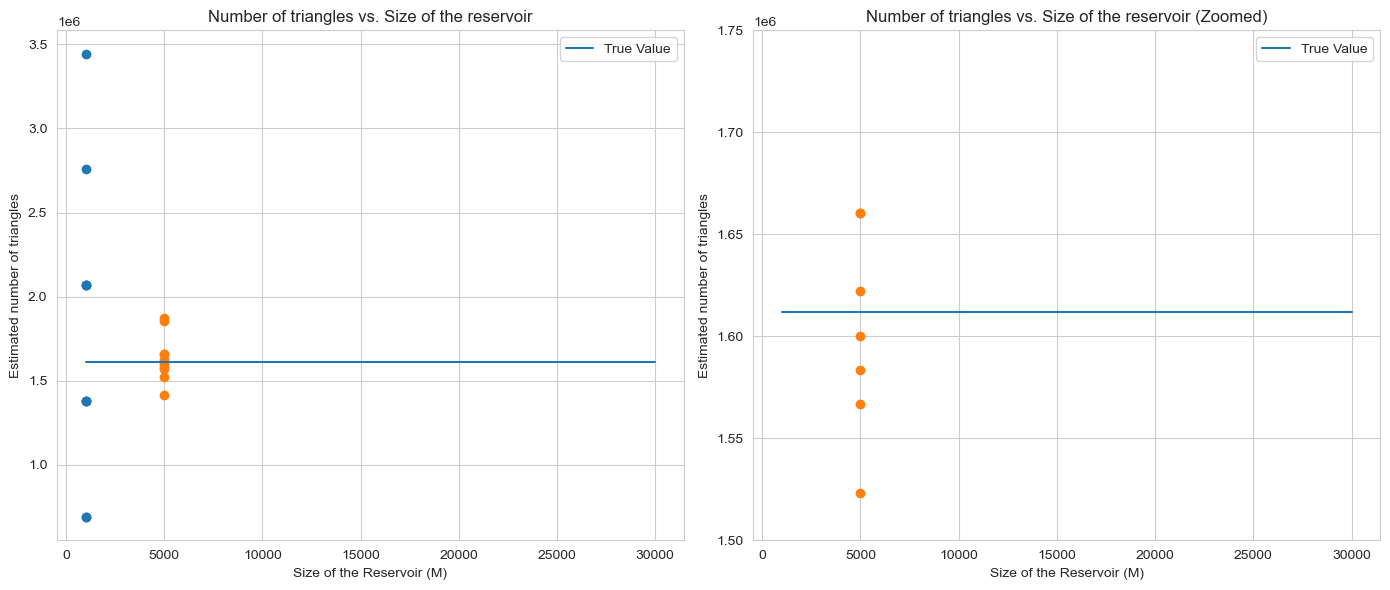

In [40]:
true_value = 1612010

# 创建并排的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 行 2 列的子图布局

# 子图 1：没有限定 y 轴的散点图
for i in range(len(M)):
    axes[0].scatter([M[i]]*10, all_estimations[i])
axes[0].plot([1000, 30000], [true_value, true_value], label="True Value")
axes[0].set_xlabel('Size of the Reservoir (M)')
axes[0].set_ylabel('Estimated number of triangles')
axes[0].set_title('Number of triangles vs. Size of the reservoir')
axes[0].legend()

# 子图 2：限定 y 轴范围的散点图
for i in range(len(M)):
    axes[1].scatter([M[i]]*10, all_estimations[i])
axes[1].plot([1000, 30000], [true_value, true_value], label="True Value")
axes[1].set_xlabel('Size of the Reservoir (M)')
axes[1].set_ylabel('Estimated number of triangles')
axes[1].set_title('Number of triangles vs. Size of the reservoir (Zoomed)')
axes[1].set_ylim(15e5, 175e4)
axes[1].legend()

# 调整布局并显示
plt.tight_layout()
plt.show()

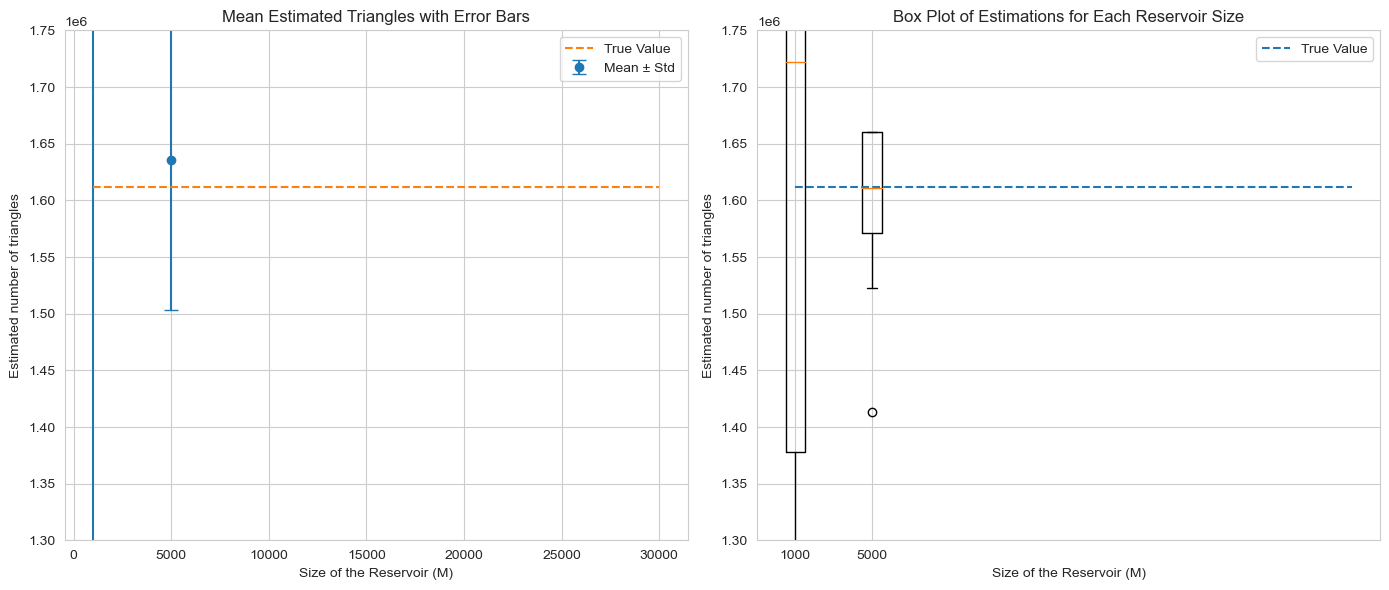

In [49]:
true_value = 1612010

# 计算均值和标准差
means = [np.mean(all_estimations[i]) for i in range(len(M))]
stds = [np.std(all_estimations[i]) for i in range(len(M))]

# 创建并排的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 行 2 列的子图布局

# 子图 1：误差棒图
axes[0].errorbar(M, means, yerr=stds, fmt='o', capsize=5, label='Mean ± Std')
axes[0].plot([1000, 30000], [true_value, true_value], label='True Value', linestyle='--')
axes[0].set_xlabel('Size of the Reservoir (M)')
axes[0].set_ylabel('Estimated number of triangles')
axes[0].set_title('Mean Estimated Triangles with Error Bars')
axes[0].set_ylim(130e4, 175e4)
axes[0].legend()

# 子图 2：箱线图
axes[1].boxplot(all_estimations, positions=M, widths=1000)
axes[1].plot([1000, 30000], [true_value, true_value], label='True Value', linestyle='--')
axes[1].set_xlabel('Size of the Reservoir (M)')
axes[1].set_ylabel('Estimated number of triangles')
axes[1].set_title('Box Plot of Estimations for Each Reservoir Size')
axes[1].set_xticks(M)  # 设置 x 轴刻度为采样大小
axes[1].set_ylim(130e4, 175e4)
axes[1].legend()

# 调整布局并显示图形
plt.tight_layout()
plt.show()

## Triest Improved

We estimate the number of triangles in the graph with the Triest Improved algorithm ten times for each M=1000, 5000, 10000, 20000, and 30000.

In [42]:
# M = [1000, 5000, 10000, 15000, 20000, 25000, 30000]
M = [1000, 5000]
iterations = 10
all_estimations2 = []

for m in M:
    print(f"\nM={m}...")
    estimations = []
    for i in range(iterations):
        print(f"\rRunning iteration {i+1}/{iterations} ...", end="")
        estimation = ImprovedTriangleCounter(file_path=data_path, max_memory=m, verbose=False).execute()
        estimations.append(estimation)
    all_estimations2.append(estimations)


M=1000...
Running iteration 10/10 ...
M=5000...
Running iteration 10/10 ...

We observe that the increase in the reservoir size produces estimates that are more precise and less variant. In comparison to the Triest Base, we can visually inspect that the estimations vary less.

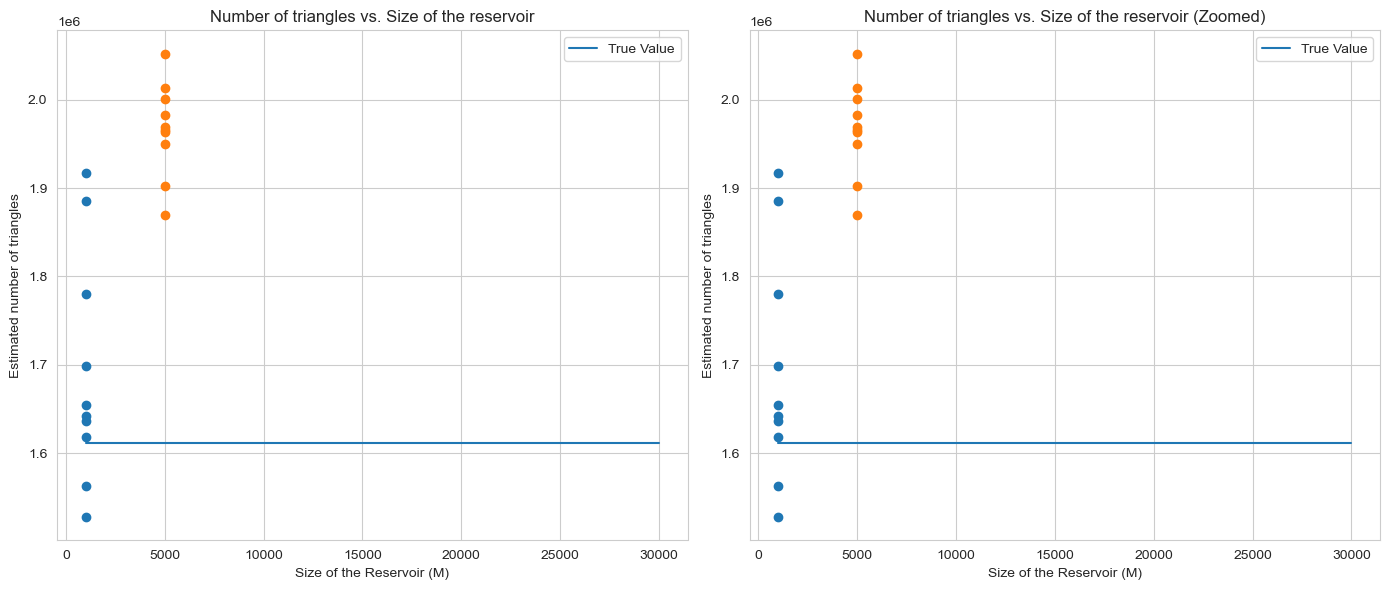

In [46]:
true_value = 1612010

# 创建并排的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 行 2 列的子图布局

# 子图 1：没有限定 y 轴的散点图
for i in range(len(M)):
    axes[0].scatter([M[i]]*10, all_estimations2[i])
axes[0].plot([1000, 30000], [true_value, true_value], label="True Value")
axes[0].set_xlabel('Size of the Reservoir (M)')
axes[0].set_ylabel('Estimated number of triangles')
axes[0].set_title('Number of triangles vs. Size of the reservoir')
axes[0].legend()

# 子图 2：限定 y 轴范围的散点图
for i in range(len(M)):
    axes[1].scatter([M[i]]*10, all_estimations2[i])
axes[1].plot([1000, 30000], [true_value, true_value], label="True Value")
axes[1].set_xlabel('Size of the Reservoir (M)')
axes[1].set_ylabel('Estimated number of triangles')
axes[1].set_title('Number of triangles vs. Size of the reservoir (Zoomed)')
axes[1].legend()

# 调整布局并显示
plt.tight_layout()
plt.show()


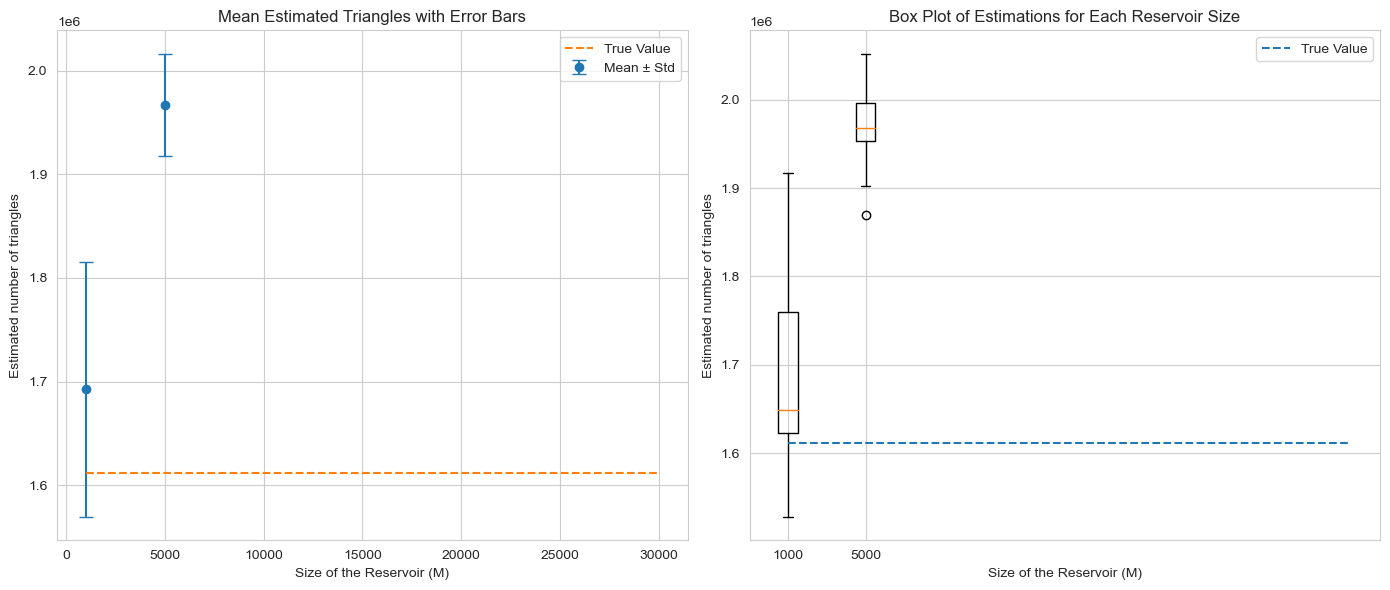

In [45]:
true_value = 1612010

# 计算均值和标准差
means = [np.mean(all_estimations2[i]) for i in range(len(M))]
stds = [np.std(all_estimations2[i]) for i in range(len(M))]

# 创建并排的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 行 2 列的子图布局

# 子图 1：误差棒图
axes[0].errorbar(M, means, yerr=stds, fmt='o', capsize=5, label='Mean ± Std')
axes[0].plot([1000, 30000], [true_value, true_value], label='True Value', linestyle='--')
axes[0].set_xlabel('Size of the Reservoir (M)')
axes[0].set_ylabel('Estimated number of triangles')
axes[0].set_title('Mean Estimated Triangles with Error Bars')
axes[0].legend()

# 子图 2：箱线图
axes[1].boxplot(all_estimations2, positions=M, widths=1000)
axes[1].plot([1000, 30000], [true_value, true_value], label='True Value', linestyle='--')
axes[1].set_xlabel('Size of the Reservoir (M)')
axes[1].set_ylabel('Estimated number of triangles')
axes[1].set_title('Box Plot of Estimations for Each Reservoir Size')
axes[1].set_xticks(M)  # 设置 x 轴刻度为采样大小
axes[1].legend()

# 调整布局并显示图形
plt.tight_layout()
plt.show()